In [81]:
import os
import sys
from datetime import datetime as dt
import unicodedata

from IPython.display import Markdown, display

import numpy as np
from scipy import ndimage

import gdal
import osr
import ogr
from gdalconst import GA_ReadOnly

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpltools import special
%matplotlib inline

import rasterio
from rasterio.mask import mask
import rasterio.plot as rioplot

import geopandas as gpd
from shapely.geometry import mapping

In [82]:
def buffer_old(outArray):
    new = []
    for numrow, row in zip(range(outArray.shape[0]), outArray):
        newrow = []
        first = next((i for i, x in enumerate(row) if x), None)
        if first is None:
            for col in row:
                newrow.append(col)
        else:
            end = row.shape[0] + ((next((i for i, x in enumerate(list(reversed(row))) if x), None) + 1) * (-1))
            for numcol, col in zip(range(row.shape[0]), row):
                if numcol == first or numcol == end:
                    col = 0
                    newrow.append(col)
                else:
                    newrow.append(col)
        new.append(newrow)
    new = np.array(new)

    new2 = []
    outArray = new.T
    for numcol, col in zip(range(outArray.shape[0]), outArray):
        newcol = []
        first = next((i for i, x in enumerate(col) if x), None)
        if first is None:
            for row in col:
                newcol.append(row)
        else:
            end = col.shape[0] + ((next((i for i, x in enumerate(list(reversed(col))) if x), None) + 1) * (-1))
            for numrow, row in zip(range(col.shape[0]), col):
                if numrow == first or numrow == end:
                    row = 0
                    newcol.append(row)
                else:
                    newcol.append(row)
        new2.append(newcol)
    new2 = np.array(new2).T

    return new2

In [83]:
# Advanced buffer
def buffer(outArray):
    new = []
    for numrow, row in zip(range(outArray.shape[0]), outArray):
        newrow = []
        first = next((i for i, x in enumerate(row) if x), None)
        if first is None:
            for col in row:
                newrow.append(col)
        else:
            end = row.shape[0] + ((next((i for i, x in enumerate(list(reversed(row))) if x), None) + 1) * (-1))
            for numcol, col in zip(range(row.shape[0]), row):
                if numcol == first or numcol == end:
                    col = 0
                    newrow.append(col)
                else:
                    newrow.append(col)
        new.append(newrow)
    new = np.array(new)

    new2 = []
    outArray = outArray.T
    for numcol, col in zip(range(outArray.shape[0]), outArray):
        newcol = []
        first = next((i for i, x in enumerate(col) if x), None)
        if first is None:
            for row in col:
                newcol.append(row)
        else:
            end = col.shape[0] + ((next((i for i, x in enumerate(list(reversed(col))) if x), None) + 1) * (-1))
            for numrow, row in zip(range(col.shape[0]), col):
                if numrow == first or numrow == end:
                    row = 0
                    newcol.append(row)
                else:
                    newcol.append(row)
        new2.append(newcol)
    new2 = np.array(new2).T
    
    result = np.where((new == 0) | (new2 == 0), 0, new)

    return result

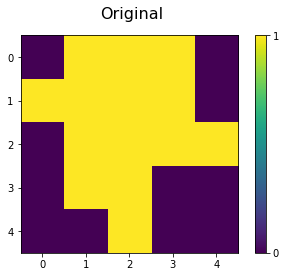

In [84]:
# Buffer Test
example_array = np.array([[0,4,5,6,0],[3,1,8,3,0],[0,7,7,3,1],[0,5,6,0,0],[0,0,1,0,0]])
example_binary = np.where(example_array > 0, 1, 0)
plt.imshow(example_binary)
plt.colorbar(ticks=[0, 1], filled=True)
plt.suptitle('Original', fontsize=16)
plt.show()

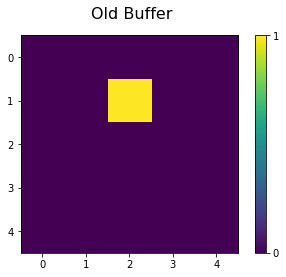

In [85]:
example_buffered = buffer_old(example_array)
buffered_binary = np.where(example_buffered > 0, 1, 0)
plt.imshow(buffered_binary)
plt.colorbar(ticks=[0, 1])
plt.suptitle('Old Buffer', fontsize=16)
plt.show()

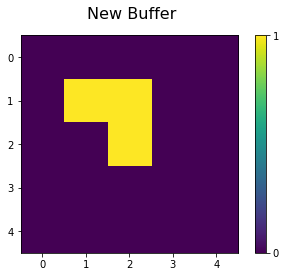

In [86]:
example_buffered = buffer(example_array)
buffered_binary = np.where(example_buffered > 0, 1, 0)
plt.imshow(buffered_binary)
plt.colorbar(ticks=[0, 1])
plt.suptitle('New Buffer', fontsize=16)
plt.show()

In [87]:
def array2raster(array, trans, proj, dest, dataType, nodataVal):
    """Array > Raster
    Save a raster from a C order array.

    :param array: ndarray, trans, proj, pathOut, dataType, nan value
    """

    # Replace nodata values
    array = np.where(np.isfinite(array), array, nodataVal)

    # Check dimensions of array
    dims = len(array.shape)
    if dims == 2:
        bandCount = 1
        bandCols = array.shape[1]
        bandRows = array.shape[0]
        array = array[np.newaxis,...]
    elif dims == 3:
        bandCount = array.shape[0]
        bandCols = array.shape[2]
        bandRows = array.shape[1]
    else:
        print "Too many dimensions."
        return -1

    # Check if file exists, delete it if it does
    if os.path.exists(dest):
         os.remove(dest)

    outdriver = gdal.GetDriverByName("GTIFF")

    # create empty output file
    # todo: raise error if outFile cannot be created (e.g. if it is open in another program)
    outFile = outdriver.Create(
                            str(dest),
                            bandCols,
                            bandRows,
                            bandCount,
                            dataType)

    outFile.SetGeoTransform(trans)
    outFile.SetProjection(proj)

    # replace np.nan by nodata value
    array = np.where(np.isnan(array), nodataVal, array)

    for band in range(bandCount):
        outFile.GetRasterBand(band+1).SetNoDataValue(nodataVal)
        outFile.GetRasterBand(band+1).WriteArray(array[band])
        outFile.FlushCache()  # Write to disk.

    del outFile

    return True

In [88]:
def Stat(Image):
    # Compute Statistics
    meanV = np.nanmean(Image)
    sdV = np.nanstd(Image)
    pSD = meanV+sdV
    nSD = meanV-sdV    

    return meanV, pSD, nSD

In [89]:
def TFMI(inDir, AOI_shp, spectral_index, field_index):

    results = []
    for timestep in os.listdir(inDir):
        
        ## Get time and raster path
        time = timestep[-8:]
        imgDir = os.path.join(inDir,timestep)
        if not os.path.isdir(imgDir):
            continue
        for idx_file in os.listdir(imgDir):
            if idx_file.endswith("_{}.tif".format(spectral_index)):
                imgPath = os.path.join(imgDir, idx_file)

        # extract the raster values values within the polygon
        with rasterio.open(imgPath) as src:
            nodata = src.nodatavals[0]
            crs_raster = src.crs.to_dict()
            
            # Read image as array with the form of the shapefile
            shapefile = gpd.read_file(AOI_shp)
            shapefile2 = shapefile.to_crs(crs_raster)
            geometries = shapefile2.geometry.values  # list of shapely geometries
            geoms = [mapping(geometries[field_index])]
                            
            try:
                out_image, out_transform = mask(src, geoms, nodata=0, crop=True)
            except ValueError as e:
                print e
                continue
                
            
        # Prepare data for writing
        data = out_image.data[0]
        Image, geotransArray, proj = data, out_transform, crs_raster
        Image = Image.astype(np.float)
        Image = np.where(Image == nodata, 0, Image)
        
        # Buffer
        Image = buffer(Image)
        
        # Statistics
        meanv, psd, nsd = Stat(Image)
        results.append({time:[meanv, psd, nsd]})

    return results

In [90]:
def plot_fields(AOI_shp, field_index): 
    # Plot the field geometries and highlight the field_index
    polygons = gpd.read_file(AOI_shp)
    indexed_field = polygons[polygons['OBJECTID'] == field_index+1]
    ax = polygons.plot(figsize=(15, 15))
    ax.set_title("Field {} of {}".format(field_index+1,len(polygons['OBJECTID'])))
    indexed_field.plot(ax=ax, color='red')
    ax.set_axis_off()

In [142]:
def plot_graph(results, field_index, spectral_index):

    # Data for Plot
    x = [dt.strptime(result.keys()[0], "%Y%m%d").date() for result in results]
    y_mean = [result.values()[0][0] for result in results]
    y_psd = [result.values()[0][1] for result in results]
    y_nsd = [result.values()[0][2] for result in results]

    # Delete missing data
    xc = []
    ymc = []
    ypc = []
    ync = []
    for x1,y1,y2,y3 in zip(x, y_mean, y_psd, y_nsd):
        if y1 != 0:
            xc.append(x1)
            ymc.append(y1)
            ypc.append(y2)
            ync.append(y3)

    # Matplotlib & Datetime
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    Fmt = mdates.DateFormatter('%Y-%m')

    # Content of X and Y
    fig, ax = plt.subplots(figsize=(10,10))
    #plt.suptitle('Spatial statistics for field {}'.format(field_index), fontsize=16)
    plt.xlabel('Time (Year-Month)')
    plt.ylabel(spectral_index)
    
    y_err = [p-m for p,m in zip(ypc,ymc)]
    special.errorfill(xc, np.array(ymc), np.array(y_err), ls='-', label='mean', label_fill='stdev', color="red")
    ax.plot(xc,ymc, '.', label='Mean')
    #ax.plot(xc,ypc, '.-', label='Positive StDev')
    #ax.plot(xc,ync, '.-', label='Negative StDev')

    # Format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(Fmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years...
    datemin = np.datetime64(x[0], 'M')
    datemax = np.datetime64(x[-1], 'M') + np.timedelta64(1, 'M')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

    # show
    #plt.legend(['mean','stdev'])
    plt.show()

# Config

In [143]:
inDir = "R:/L2A_MAJA/02_S2_L2A_Indices/29SPC"
AOI_shp = "T:/Processing/2705_LandSense/01_RawData/Ancillary_Data/DemoCase3/Spain/ZEPA_Llanos_albuera_2018_merged.shp"
field_index = 0
spectral_indices = ["MNDWI","NDVI","NDWI","RPIre"]

# Main

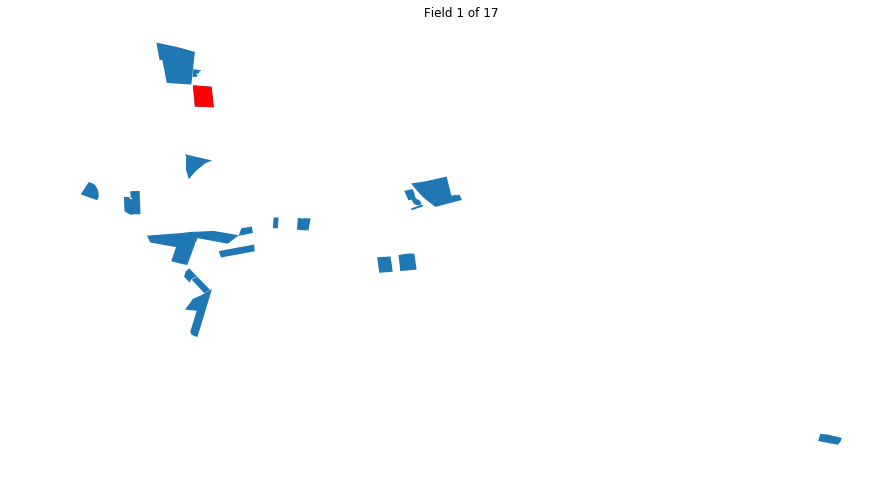

In [144]:
# Plot the field geometries and highlight the selected field (field_index)
plot_fields(AOI_shp, field_index)

In [145]:
# Get Field Type Attribute
polygons=gpd.read_file(AOI_shp)
type_title = polygons['Type'][field_index]
type_title = unicodedata.normalize('NFKD', type_title).encode('ascii','ignore')

<center>**Crop Type: Nuevos Espalderas**</center>

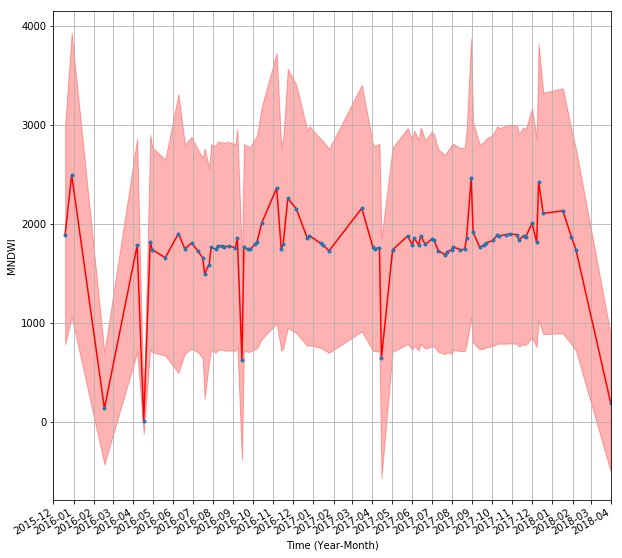

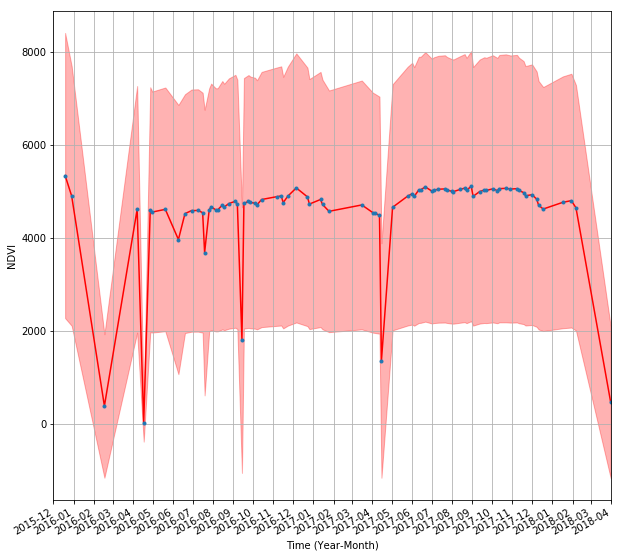

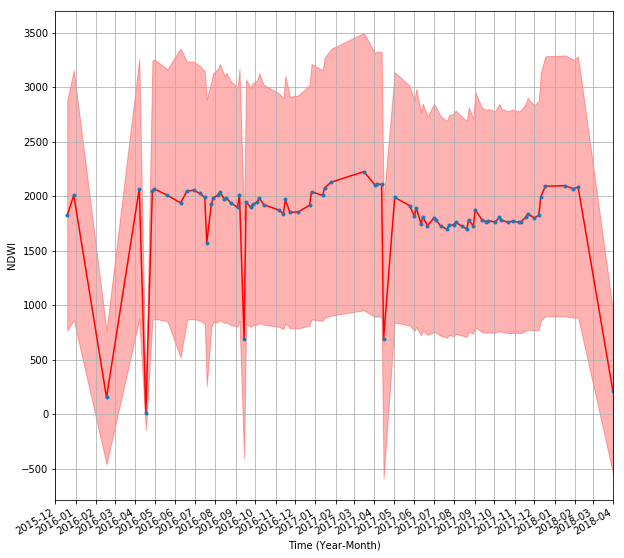

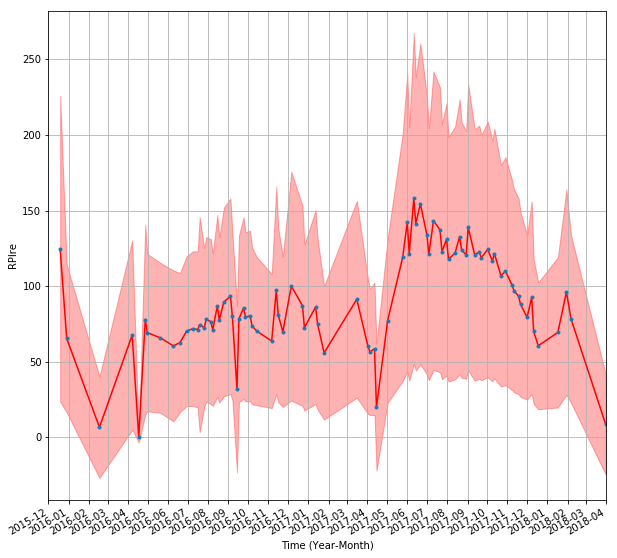

In [146]:
# For each index, the statistics are calculated and plotted
display(Markdown("<center>**Crop Type: {}**</center>".format(type_title)))

for spectral_index in spectral_indices:
    results = TFMI(inDir, AOI_shp, spectral_index, field_index)
    plot_graph(results, field_index, spectral_index)